# 4개 모델 성능 비교
```
4개 모델 성능 비교표
        
    모델	Accuracy	Recall (flood=1)	ROC AUC
RandomForest	0.9811	         0.8000	                0.9843
XGBoost     	0.9641	         0.8765              	0.9775
LSTM+CNN	0.5873	         0.8642              	0.7688
Transformer	0.7299	         0.6790              	0.7812

해석 요약
RandomForest: 전체적으로 가장 안정적. Accuracy, Recall, ROC AUC 모두 우수.

XGBoost: 침수 예측(Recall)에 가장 뛰어남. 성능 균형 좋음.

LSTM+CNN: Accuracy는 낮지만 Recall은 높아, 침수 감지엔 민감한 편.

Transformer: Recall은 나쁘지 않지만 Precision이 낮고 전체 정확도도 낮은 편.
```

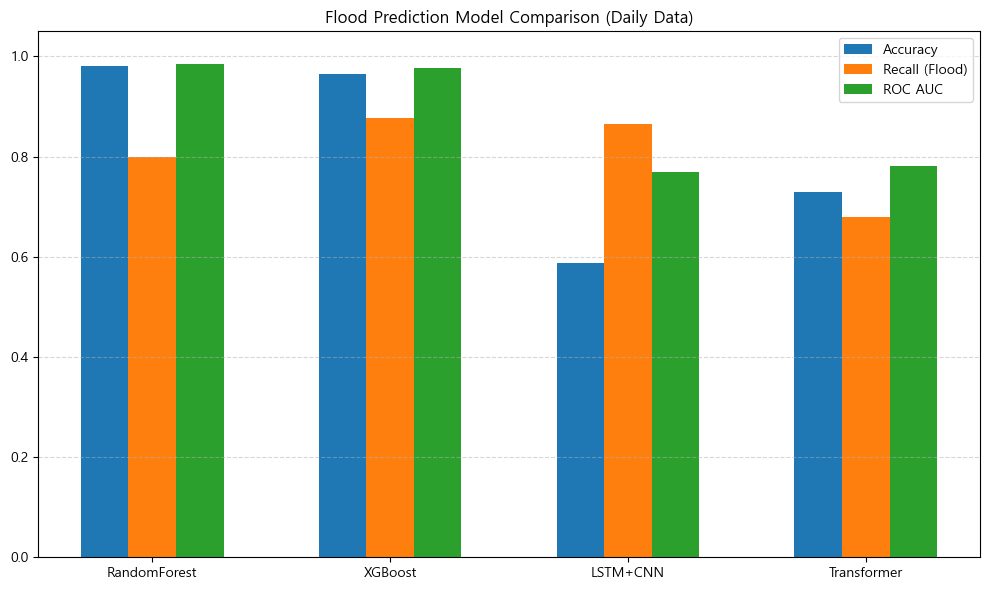

In [17]:
import matplotlib.pyplot as plt

models = ["RandomForest", "XGBoost", "LSTM+CNN", "Transformer"]
accuracy = [0.9811, 0.9641, 0.5873, 0.7299]
recall = [0.8000, 0.8765, 0.8642, 0.6790]
roc_auc = [0.9843, 0.9775, 0.7688, 0.7812]

plt.figure(figsize=(10, 6))
x = range(len(models))

plt.bar(x, accuracy, width=0.2, label="Accuracy", align="center")
plt.bar([i + 0.2 for i in x], recall, width=0.2, label="Recall (Flood)", align="center")
plt.bar([i + 0.4 for i in x], roc_auc, width=0.2, label="ROC AUC", align="center")

plt.xticks([i + 0.2 for i in x], models)
plt.ylim(0, 1.05)
plt.title("Flood Prediction Model Comparison (Daily Data)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("daily_model_comparison.png")
plt.show()

# 한글설정, 워닝제거

In [1]:
# 한글설정
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 깨짐 방지

#워닝 제거
import warnings
warnings.filterwarnings('ignore')

# api key 활용 및 데이터 수집

In [2]:
import os
from dotenv import load_dotenv
OPENWEATHER_API_KEY = load_dotenv('.env')
OPENWEATHER_API_KEY = os.getenv('OPENWEATHER_API_KEY')
# print(os.getenv('OPENWEATHER_API_KEY'))

# 데이터 준비 및 전처리

In [9]:
import pandas as pd
df = pd.read_csv("asos_seoul_daily_with_flood_risk.csv")
print(df.columns.tolist())

['tm', 'avgTa', 'minTa', 'maxTa', 'sumRn', 'avgWs', 'avgRhm', 'avgTs', 'avgTd', 'avgPs', 'flood_risk']


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 1. 데이터 로딩
df = pd.read_csv("asos_seoul_daily_with_flood_risk.csv")

# 2. 결측치 처리 (간단하게 중앙값으로 대체)
df.fillna(df.median(numeric_only=True), inplace=True)

# 3. 특성과 타겟
features = features = [
    'avgTa',  # 평균기온
    'minTa',  # 최저기온
    'maxTa',  # 최고기온
    'sumRn',  # 일강수량
    'avgWs',  # 평균풍속
    'avgRhm', # 평균습도
    'avgTs',  # 평균지면온도
    'avgTd',  # 평균이슬점
    'avgPs'   # 평균해면기압
]
target = 'flood_risk'

# 4. 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])
y = df[target].values

# LSTM + CNN ML

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. 데이터 불러오기
df = pd.read_csv('asos_seoul_daily_with_flood_risk.csv')

# 2. 사용 컬럼
features = ['avgTa', 'minTa', 'maxTa', 'sumRn', 'avgWs', 'avgRhm', 'avgTs', 'avgTd', 'avgPs']
X = df[features]
y = df['flood_risk']

# 3. 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 4. 슬라이딩 윈도우
def create_sequences(X, y, window_size=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y.values, window_size=7)

# 5. 학습 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42)

# 6. SMOTE 적용
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_reshaped, y_train)
X_train_sm = X_train_sm.reshape((-1, 7, len(features)))

# 7. 모델 정의
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(7, len(features))))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 8. 학습
es = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train_sm, y_train_sm, validation_split=0.2, epochs=30, batch_size=32, callbacks=[es])

Epoch 1/30
129/129 [==============================] - 2s 10ms/step - loss: 0.5710 - accuracy: 0.6862 - val_loss: 0.6819 - val_accuracy: 0.7868
Epoch 2/30
129/129 [==============================] - 1s 6ms/step - loss: 0.5372 - accuracy: 0.7174 - val_loss: 0.7561 - val_accuracy: 0.7361
Epoch 3/30
129/129 [==============================] - 1s 6ms/step - loss: 0.5343 - accuracy: 0.7199 - val_loss: 0.5681 - val_accuracy: 0.8199
Epoch 4/30
129/129 [==============================] - 1s 6ms/step - loss: 0.5416 - accuracy: 0.7028 - val_loss: 0.5474 - val_accuracy: 0.8598
Epoch 5/30
129/129 [==============================] - 1s 6ms/step - loss: 0.5332 - accuracy: 0.7167 - val_loss: 0.6346 - val_accuracy: 0.7945
Epoch 6/30
129/129 [==============================] - 1s 6ms/step - loss: 0.5285 - accuracy: 0.7206 - val_loss: 0.7013 - val_accuracy: 0.7303
Epoch 7/30
129/129 [==============================] - 1s 6ms/step - loss: 0.5244 - accuracy: 0.7274 - val_loss: 0.8723 - val_accuracy: 0.5667
Epoch

# 평가

In [12]:
# 9. 평가
y_pred = model.predict(X_test).flatten()
y_pred_binary = (y_pred > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_binary))
print("\nClassification Report:\n", classification_report(y_test, y_pred_binary, digits=4))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred))


23/23 [==============================] - 0s 5ms/step
Confusion Matrix:
 [[354 287]
 [ 11  70]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9699    0.5523    0.7038       641
           1     0.1961    0.8642    0.3196        81

    accuracy                         0.5873       722
   macro avg     0.5830    0.7082    0.5117       722
weighted avg     0.8831    0.5873    0.6607       722


ROC AUC Score: 0.7687640838966892


#  LSTM+CNN (일별 데이터) 평가 결과 요약
```
Metric	Value
Accuracy	58.73%
Precision (Flood)	19.61%
Recall (Flood)	86.42%
F1-score (Flood)	31.96%
ROC AUC Score	0.7688

Flood(침수) class의 recall이 매우 높음 (86.4%):
침수 발생은 거의 다 잡아냄

precision이 낮음 (19.6%):
침수 아님인데도 침수라고 잘못 판단하는 경우가 많음. false positive 많음.

정확도(accuracy)는 낮음:
imbalance 때문에 전체 성능은 좀 떨어져 보이지만 실제 침수 탐지 목적에는 의미 있음.
```


# 모델 저장하기

In [13]:
from tensorflow.keras.models import load_model

# 저장
model.save("lstm_cnn_daily_model.h5")

# 불러오기 (나중에 쓸 때)
# model = load_model("lstm_cnn_daily_model.h5")

# Confusion Matrix 시각화

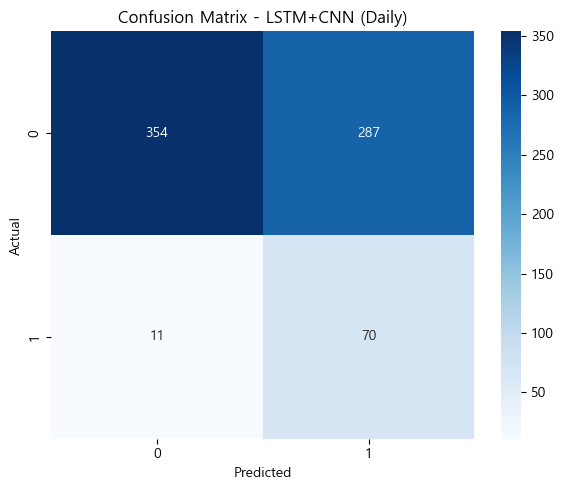

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LSTM+CNN (Daily)")
plt.tight_layout()
plt.savefig("lstm_cnn_daily_confusion_matrix.png")
plt.show()

# ROC Curve 시각화

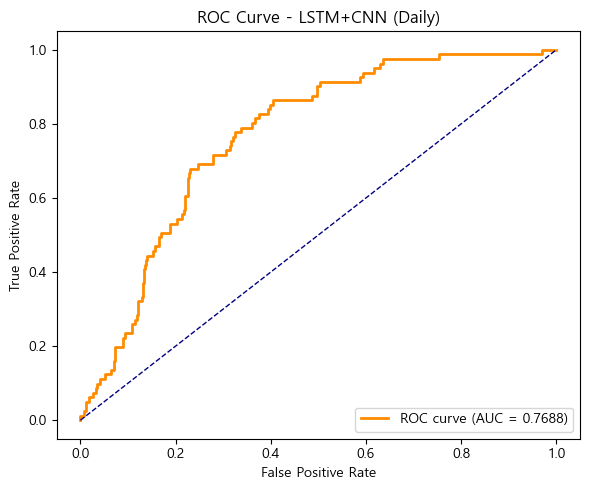

In [15]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LSTM+CNN (Daily)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("lstm_cnn_daily_roc_curve.png")
plt.show()

# Precision-Recall Curve 시각화

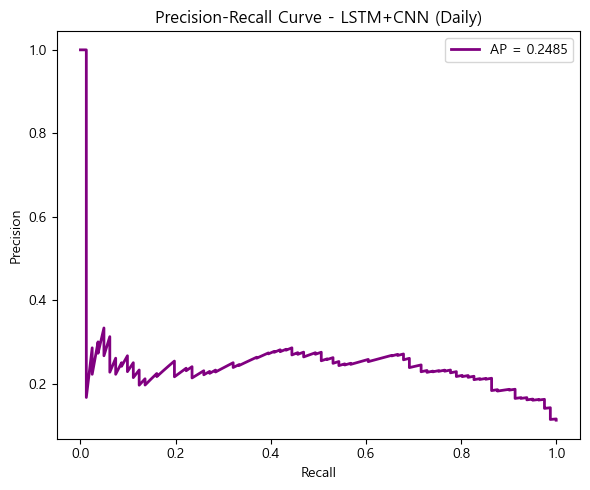

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred)
ap_score = average_precision_score(y_test, y_pred)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='purple', lw=2, label=f"AP = {ap_score:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - LSTM+CNN (Daily)")
plt.legend()
plt.tight_layout()
plt.savefig("lstm_cnn_daily_pr_curve.png")
plt.show()